This notebook presents a synthetic use case of **plainKrige**, with a whole workflow, from importing data to plotting the result. 

For details about faults, see the notebook *fault_modeling.ipynb*.

For details about variography, see the notebook *variography.ipynb*

**Dataset :**

This example contains data about elevation of 8 different horizons in the area of Landres, France. The horizons are considered conform and thus basically parallel. 

In [1]:
import pyvista as pv
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
%matplotlib inline

# Set common plotting parameters
clim_min, clim_max = -40, 400

# Load data

## Formations

In [3]:
try:
    df_contacts = pd.read_csv("data/contacts.csv")
    df_faults = pd.read_csv("data/failles.csv")
except:
    df_contacts = pd.read_csv("demo/data/contacts.csv")
    df_faults = pd.read_csv("demo/data/failles.csv")

all_formation_names = df_contacts['Formation'].unique()
print(f"Formation names : {all_formation_names}")

Formation names : ['FF' 'RP' 'JS' 'G' 'JP' 'B' 'N' 'V']


## Faults

In [4]:
all_faults_names = ['F_Joudreville', 'F_Amermont', 'F_Bouligny', 'F_Landres','F_NorroyLeSec', 'F_Bonvillers', 'F_MercyLeHautCrusnes',
    'F_AdunTiche', 'F_Mediane', 'F_MedianeBis', 'F_AudunLeRoman', 'F_Ottange', 'F_Angevillers', 'F_AngevillersBis','F_Rochonvillers', 
    'F_Adelheid', 'F_Kraemer', 'F_FontoyBis', 'F_Fontoy', 'F_Sancy','F_Bassompierre', 'F_FontoyTer','F_Brabant', 'F_Avril', 'F_Aumetz', 
    'F_FontoyQuat', 'F_Hayange','F_AngevillersTer', 'F_AngevillersQuat', 'F_Pensbrunnen', 'F_Bois']

all_faults = [] 
for name in all_faults_names:
    f = df_faults[df_faults["Nom"] == name]
    f = np.column_stack((f.X.values, f.Y.values))
    all_faults.append(f)

## Plot dataset

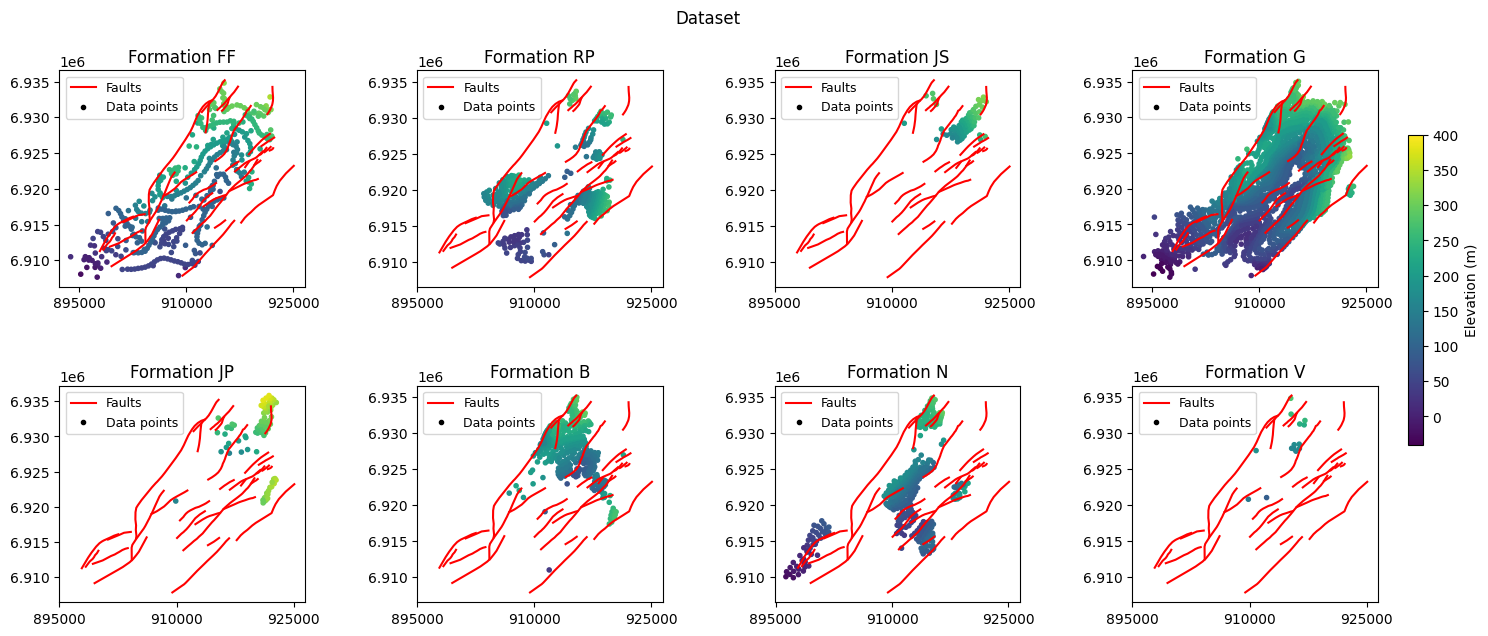

In [5]:
fig, ax = plt.subplots(2,4, figsize=(15,7))
fig.tight_layout(pad=5.)

for i in range(2):
    for j in range(4):
        # Retrieve data for each formation
        formation_ = df_contacts[df_contacts['Formation'] == all_formation_names[i*4+j]]
        formation_ = formation_.dropna() 
        x_, y_ = formation_.X_L93.values, formation_.Y_L93.values
        data_pts_ = np.column_stack((x_,y_))
        data_ = formation_.Zt.values 

        data_plot = ax[i, j].scatter(x_,y_,c=data_, marker='.',clim=[clim_min, clim_max])
        for f in all_faults:
            ax[i, j].plot(f[...,0], f[...,1], 'r')
        ax[i,j].set_title(f"Formation {all_formation_names[i*4+j]}")

        ax[i,j].set_xticks([895000, 910000, 925000])
        # Add legend
        fault_legend = mlines.Line2D([],[], color='r', label="Faults")
        data_legend = mlines.Line2D([],[], color='k',linestyle="none", marker='.', label="Data points")
        ax[i,j].legend(handles=[fault_legend, data_legend], fontsize=9)

cax = fig.add_axes([ax[1,3].get_position().x1 + 0.02,
                    (ax[0,0].get_position().y0 + ax[1,0].get_position().y0)/2,
                    0.01,
                    ax[1,0].get_position().y1])


plt.colorbar(data_plot, label="Elevation (m)", cax=cax)
fig.suptitle("Dataset")

plt.show()

In [6]:
# Bounding box of the dataset
xmin, xmax = df_contacts['X_L93'].min() - 1000, df_contacts['X_L93'].max() + 2000
ymin, ymax = df_contacts['Y_L93'].min() - 1000, df_contacts['Y_L93'].max() + 1000

In [7]:
# Grid resolution along axis x and y, in meters
x_resolution = 150
y_resolution = 150

nb_pts_x, nb_pts_y = int((xmax-xmin)/x_resolution), int((ymax-ymin)/y_resolution)

dx = np.linspace(xmin, xmax, nb_pts_x)
dy = np.linspace(ymin, ymax, nb_pts_y)
x_grid, y_grid = np.meshgrid(dx, dy)
grid_points = (np.column_stack((x_grid.flat, y_grid.flat)))
print(f"Created rectangular interpolation grid of size {nb_pts_x}x{nb_pts_y} points, "
      f"with a resolution of {x_resolution}x{y_resolution} m.")

Created rectangular interpolation grid of size 216x201 points, with a resolution of 150x150 m.


# Build drifts

Build drift model associated with the fault network. For more details on the drifts, see *fault_modeling.ipynb*.

In [8]:
from krigeo import build_network

In [9]:
matrix = np.array([
       [ 0,  0, -1, 0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 0, -1,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 0, 0, 0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0, 0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0, 0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0],
       [ 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 0,  1, -1,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 0, -1,  1,  0, 0,  0,  0,  0,  1,  0,  0, 0, -1, -1,  0,  0,  0,  1,  0,  0,  1,  0,  0, 0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0, 0, 0, 0,  0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 0,  0, 0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  1, -1, -1,  0, -1,  0,  0, -1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 0, 0, 0,  0,  0, 0, 0,  0, 0,  0, 0, 0, 0,  0,  0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  -1,  0,  0,  0,  0, -1,  1,  1,  0,  0,  0, 0, -1, -1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0, 0,  0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 0, 0,  0,  0,  0,  0,  0,  0, 0, 0,  0,  0, 0,  0,  0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0, 0],
       [ 0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0, 0, 0, 0, 0,  0,  0, 0, 0,  0, 0, 0,  0, 0,  0, 0,  0, 0, 0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       ],
      dtype=int)

In [10]:
model = 'gaussian'
model_range = np.round(np.linalg.norm([f[0] - f[-1] for f in all_faults], axis=-1)/2, 0)

print(f"Drift parameters : \n"
      f"    - Model : {model}\n"
      f"    - Range of influence of each fault : {model_range}\n")

Drift parameters : 
    - Model : gaussian
    - Range of influence of each fault : [2498. 1396. 3353. 1559. 4657. 5334. 9511. 2743. 2027. 1203. 2823. 4602.
 2391.  510. 2060. 1077. 1941. 2165. 6844. 2314. 1081. 1764. 2606. 5290.
 1981.  535. 5425.  681.  562.  300.  881.]



In [11]:
drift_params = []
for r in model_range:
    drift_params.append({"range":r})

drift_params = np.asarray(drift_params)

Clean dataset because some faults are inconsistent with data...

In [12]:
faults_to_remove = [1,13,25,27,28,29]

corrected_matrix = np.delete(matrix, faults_to_remove, axis=0)
corrected_matrix = np.delete(corrected_matrix, faults_to_remove, axis=1)


drift_params = np.delete(drift_params, faults_to_remove)

In [13]:
corrected_faults = []
for i, f in enumerate(all_faults):
    if i not in faults_to_remove:
        corrected_faults.append(f)

In [14]:
drifts = build_network(corrected_faults, models=model, params=drift_params, relations=corrected_matrix)

In [15]:
drifts.__class__.__name__

'DriftsNetwork'

In [16]:
all_computed_drifts = drifts(grid_points)

Plot drift model for each fault of the network

In [17]:
def plot_drifts(start_at):
    fig, ax = plt.subplots(2,4, figsize=(15,8))
    fig.suptitle(f"Proposed drifts for faults {start_at} to {start_at+7}")
    
    n_skipped = 0
    if start_at > 0:
        for removed in faults_to_remove:
            if start_at > removed:
                n_skipped += 1
    
    for i in range(2):
        for j in range(4): 
            fault_index = start_at+i*4+j

            if fault_index not in faults_to_remove:
                d = ax[i,j].imshow(all_computed_drifts[fault_index-n_skipped].reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
                ctr = ax[i,j].contour(np.abs(all_computed_drifts[fault_index-n_skipped].reshape((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), levels=[0.05], colors='black',linestyles='dotted')
            else:
                d = ax[i,j].imshow(np.zeros((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
                n_skipped += 1
            for f in all_faults:
                ax[i,j].plot(f[...,0], f[...,1], 'r')
            ax[i,j].plot(all_faults[fault_index][...,0], all_faults[fault_index][...,1], 'g')

            ax[i,j].set_title(f"fault {fault_index} - {all_faults_names[fault_index]}")

    cax = fig.add_axes([ax[1,3].get_position().x1+0.02,
                        (ax[1,0].get_position().y0 + ax[0,0].get_position().y0)/2,
                        0.01,
                        ax[1,0].get_position().y1-ax[1,0].get_position().y0])

    plt.colorbar(d, label="Drift", cax=cax)

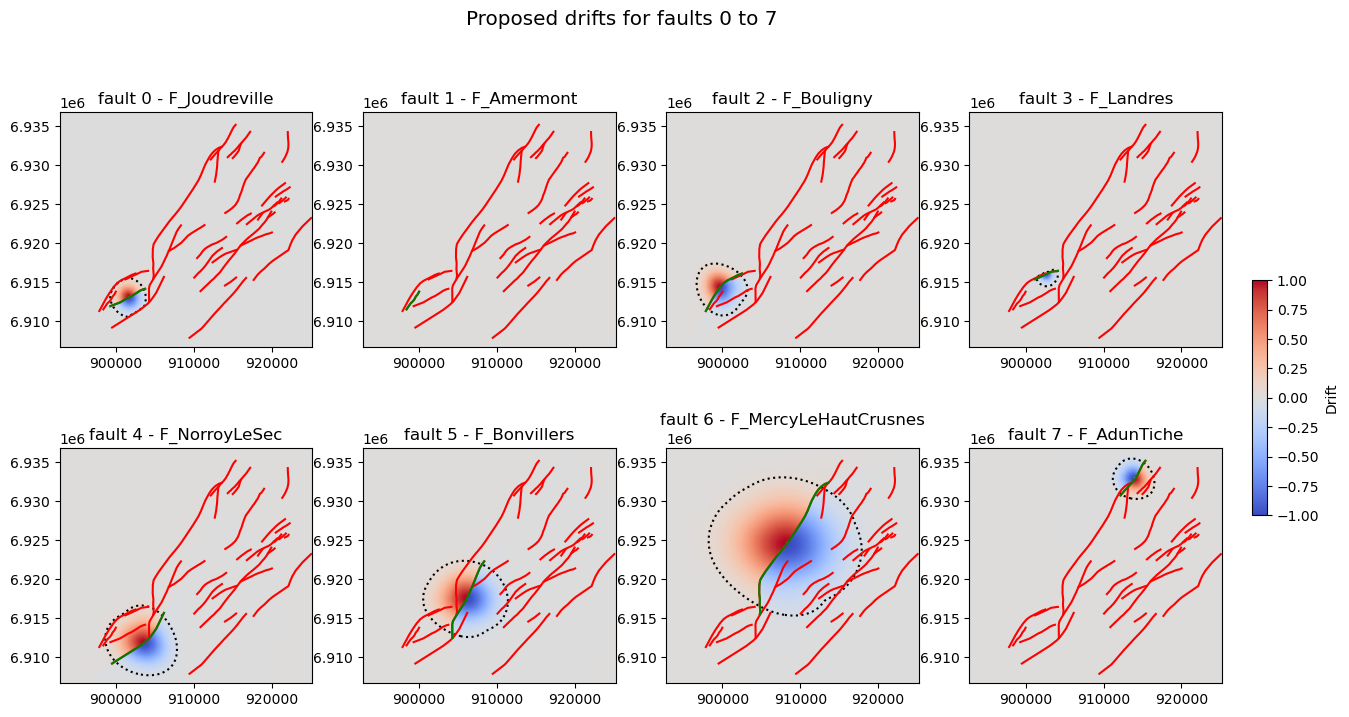

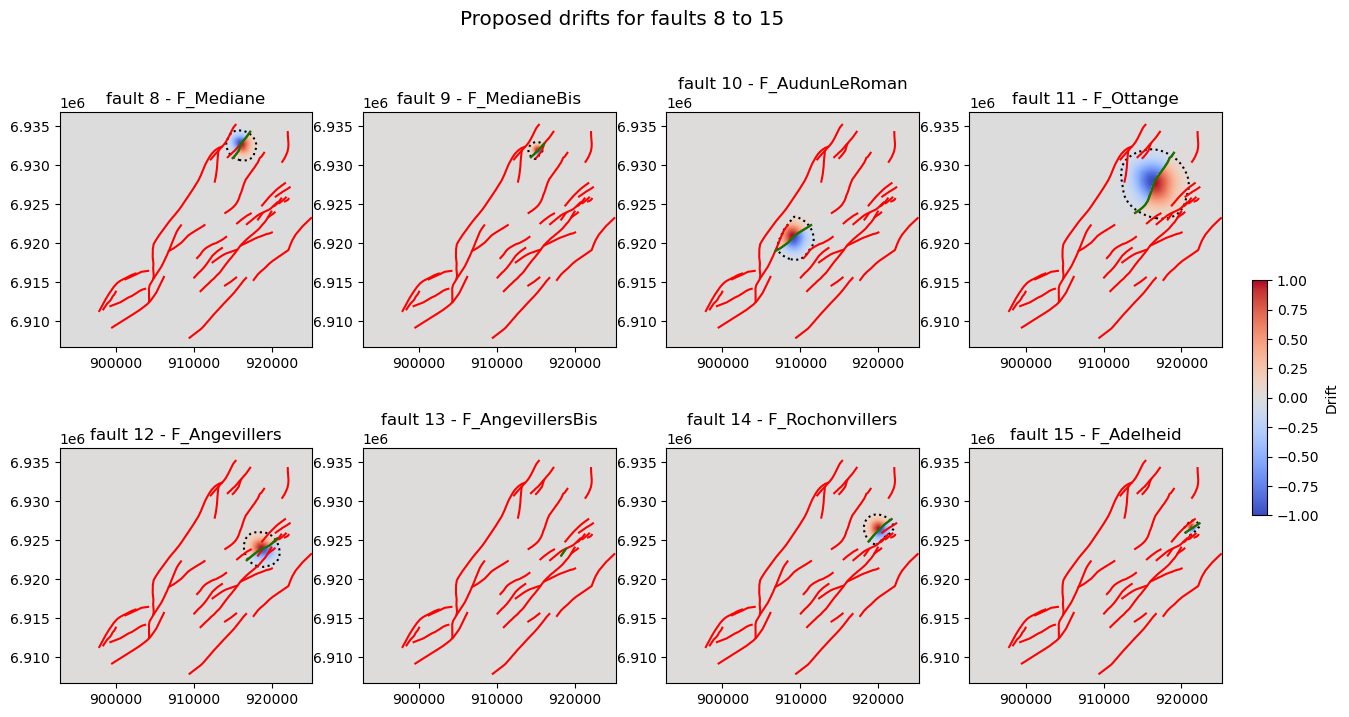

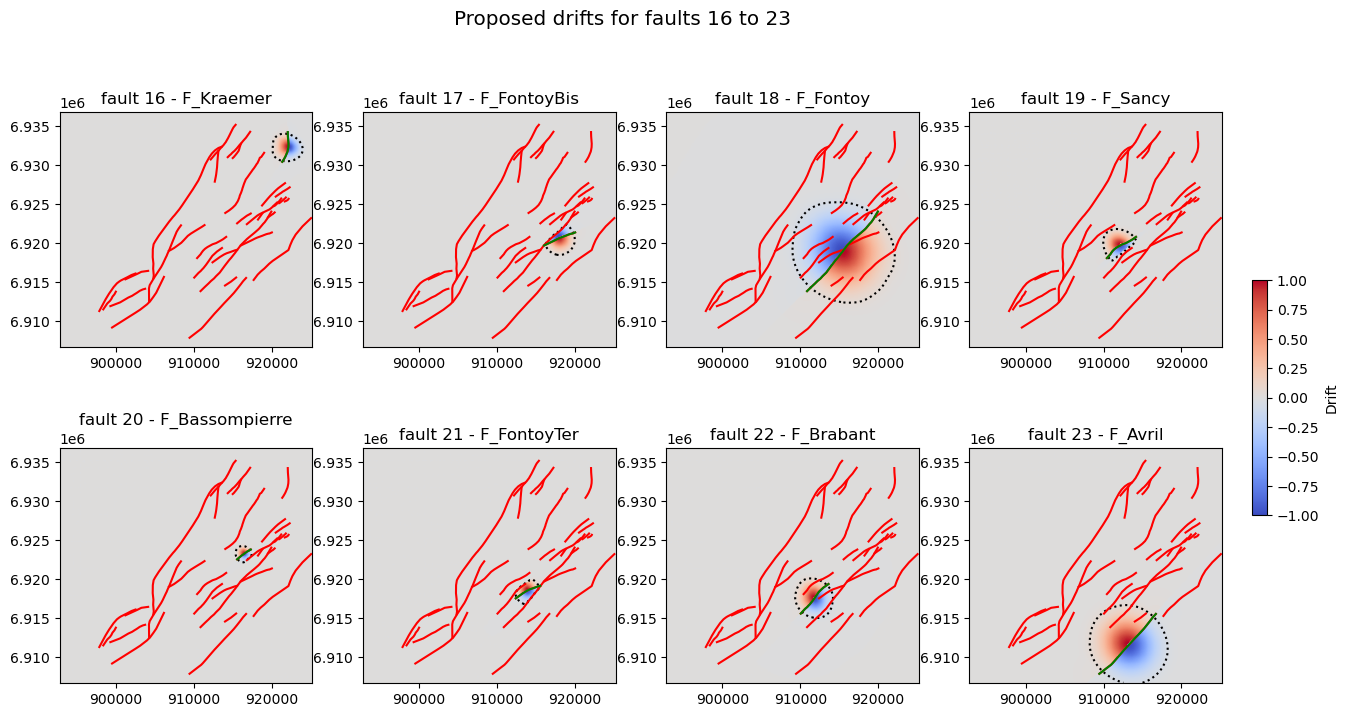

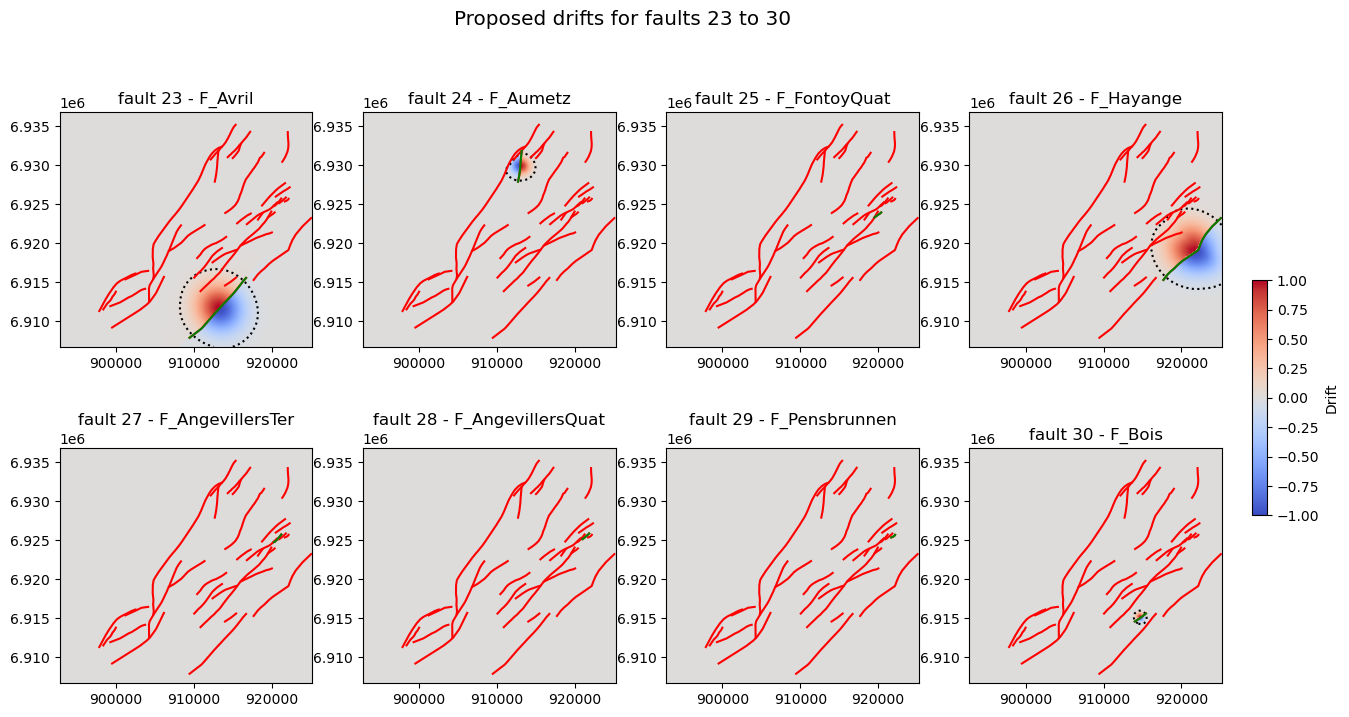

In [18]:
plot_drifts(0)
plot_drifts(8)
plot_drifts(16)
plot_drifts(23)

plt.show()

# Build variogram

Build variogram model associated with data. For more details on variography, see *variography.ipynb*.

In [48]:
from krigeo import covariance_models

In [49]:
vario_type = "gaussian"
range_vario = 7_000
sill_vario = 4_000
nugget = 500

In [50]:
covariance = covariance_models[vario_type](sill=sill_vario, range=range_vario, nugget=nugget)

In [51]:
covariance.__class__.__name__, covariance._params

('GaussianCovariance',
 {'range': 7000, 'sill': 4000, 'nugget': 500, 'scale': 1.0})

# Krige

Krige formation 'G', which is the horizon associated with the most data points.

In [52]:
formation_name = 'G'

In [53]:
formation = df_contacts[df_contacts['Formation'] == formation_name]
formation = formation.dropna() # Drop rows with missing values

# Get data points
x, y = formation.X_L93.values, formation.Y_L93.values
data_pts = np.column_stack((x,y))
# get elevation at data points 
data = formation.Zt.values 

print(f"Selected formation : {formation_name}\n"
      f"Min and max values of the data for formation {formation_name} : {data.min()}, {data.max()} m.")

Selected formation : G
Min and max values of the data for formation G : -40.2, 330.0 m.


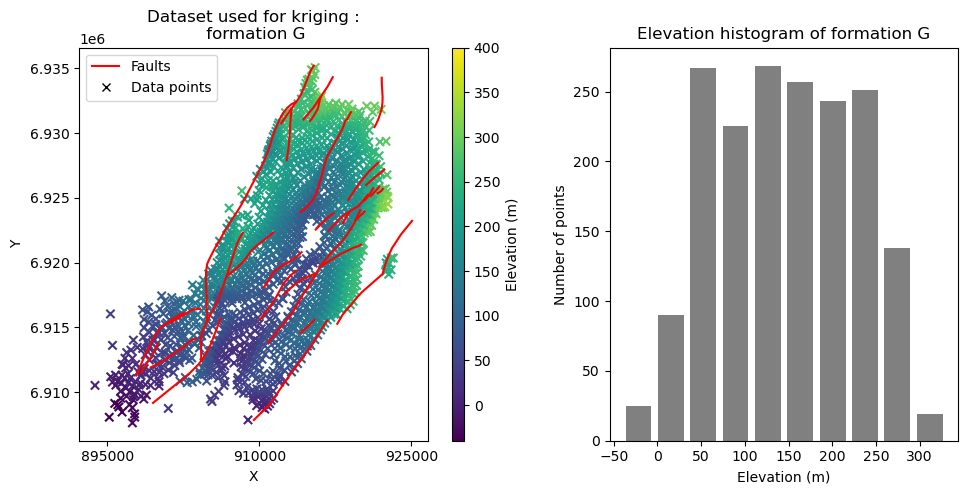

In [54]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,7))
fig.tight_layout(pad=10.0)

# Dataset
data_plot = ax[0].scatter(x,y,c=data, marker='x',clim=[clim_min, clim_max])
for f in all_faults:
    ax[0].plot(f[...,0], f[...,1], 'r')
ax[0].set_title(f"Dataset used for kriging :\n formation {formation_name}")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[0].set_xticks([895000, 910000, 925000])
# Add legend
fault_legend = mlines.Line2D([],[], color='r', label="Faults")
data_legend = mlines.Line2D([],[], color='k',linestyle="none", marker='x', label="Data points")
ax[0].legend(handles=[fault_legend, data_legend])

cax = fig.add_axes([ax[0].get_position().x1 + 0.02,
                    ax[1].get_position().y0,
                    0.01,
                    ax[0].get_position().y1 - ax[0].get_position().y0])

plt.colorbar(data_plot, label="Elevation (m)", cax=cax)

# Histogram 
ax[1].hist(data, rwidth=0.8, color='grey')
ax[1].set_title(f"Elevation histogram of formation {formation_name}")
ax[1].set_xlabel("Elevation (m)")
ax[1].set_ylabel("Number of points")

plt.show()

In [55]:
from krigeo import UniversalKriging, OrdinaryKriging

Create the kriging systems, then solve it on every point of the interpolation grid.

In [ ]:
lag_max = 10_000
nbins = 10

In [56]:
univ_fct = UniversalKriging(data_pts, lag_max, nbins, data, covariance=covariance, drifts=drifts)
krige = univ_fct(grid_points)

In [57]:
ord_fct = OrdinaryKriging(data_pts, lag_max, nbins, data, covariance=covariance)
krige_ord = ord_fct(grid_points)

# Plot result

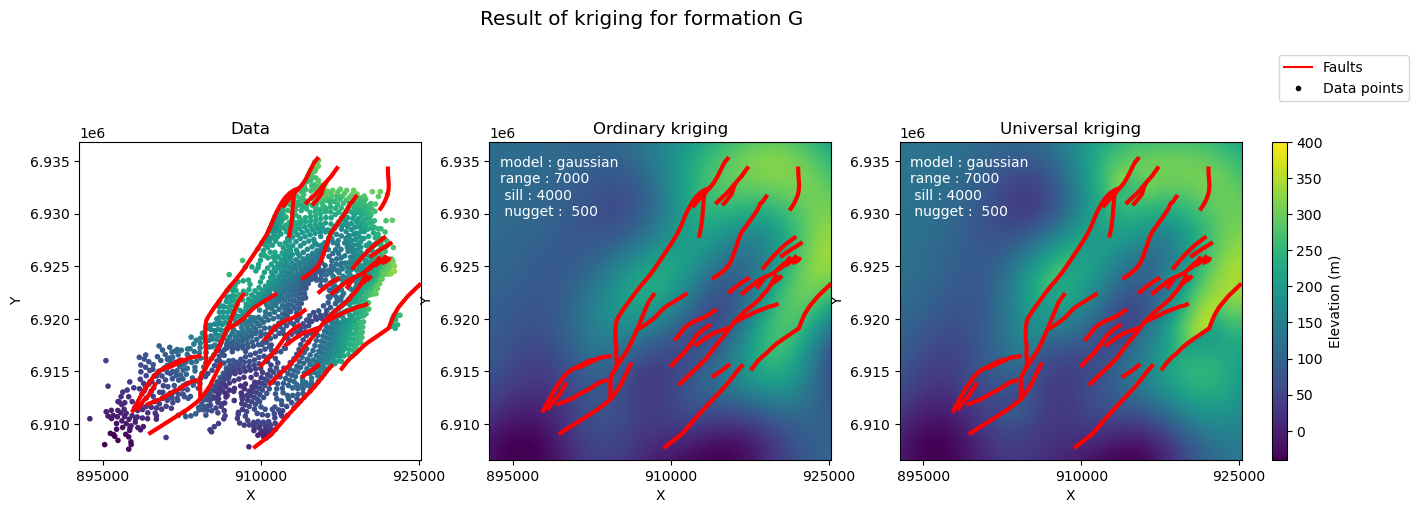

In [58]:
# Plot result
%matplotlib inline

plot_contour = False

fig, ax = plt.subplots(1,3, figsize=(15,6), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1]})
# Data
ax[0].imshow(np.empty((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), alpha=0.)
data_plot = ax[0].scatter(x,y,c=data, marker='.',clim=[clim_min, clim_max])

# Ordinary kriging
ord = ax[1].imshow(krige_ord.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])
if plot_contour: ctr_ord = ax[1].contour(krige_ord.reshape((nb_pts_y, nb_pts_x)), origin="lower", levels=[-50,50,150,250,350,450], extent=(xmin, xmax, ymin, ymax), cmap="Oranges")

# Universal kriging
univ = ax[2].imshow(krige.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])
if plot_contour: ctr_univ = ax[2].contour(krige.reshape((nb_pts_y, nb_pts_x)), origin="lower", levels=[-50,50,150,250,350,450], extent=(xmin, xmax, ymin, ymax), cmap="Oranges")

# Faults
for f in all_faults:
        ax[0].plot(f[...,0], f[...,1], 'r', linewidth=3)
        ax[1].plot(f[...,0], f[...,1], 'r', linewidth=3)
        ax[2].plot(f[...,0], f[...,1], 'r', linewidth=3)

ax[0].set_title("Data")
ax[1].set_title("Ordinary kriging")
ax[2].set_title("Universal kriging")

plt.suptitle(f"Result of kriging for formation {formation_name}")

ax[0].set_xlabel("X")
ax[1].set_xlabel("X")
ax[2].set_xlabel("X")

ax[0].set_ylabel("Y")
ax[1].set_ylabel("Y")
ax[2].set_ylabel("Y")

ax[0].set_xticks([895000, 910000, 925000])
ax[1].set_xticks([895000, 910000, 925000])
ax[2].set_xticks([895000, 910000, 925000])

# Kriging parameters
ax[1].text(xmin + 1000, ymax - 7000, f"model : {vario_type}\nrange : {range_vario:4.0f}\n sill : {sill_vario:4.0f}\n nugget : {nugget:4.0f}", color='white')
ax[2].text(xmin + 1000, ymax - 7000, f"model : {vario_type}\nrange : {range_vario:4.0f}\n sill : {sill_vario:4.0f}\n nugget : {nugget:4.0f}", color='white')

cax = fig.add_axes([ax[2].get_position().x1+0.02,
                    ax[1].get_position().y0,
                    0.01,
                    ax[1].get_position().y1-ax[1].get_position().y0])

fault_legend = mlines.Line2D([], [], color='r', label="Faults")
data_legend = mlines.Line2D([], [], color='k', label="Data points", linestyle="none", marker='.')
plt.legend(handles=[fault_legend, data_legend], facecolor="white", loc="center left", bbox_to_anchor=(0.,1.2))

cbar = plt.colorbar(univ, label="Elevation (m)", cax=cax)
if plot_contour: cbar.add_lines(ctr_ord)

plt.show()

# 3d visualisation

In [59]:
vertical_exaggeration = 8

In [60]:
surf_ord = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_ord)))
surf_ord = surf_ord.delaunay_2d()

surf_univ = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige)))
surf_univ = surf_univ.delaunay_2d()

In [ ]:
surf_ord["elevation (m)"] = surf_ord.points[...,2]
surf_ord.points[...,2]*=vertical_exaggeration

surf_univ["elevation (m)"] = surf_univ.points[...,2]
surf_univ.points[...,2]*=vertical_exaggeration

In [ ]:
plotter = pv.Plotter(notebook=True)

mesh_ord = plotter.add_mesh(surf_ord, clim=[clim_min, clim_max])
mesh_univ = plotter.add_mesh(surf_univ, clim=[clim_min, clim_max])

# contours_ord = surf_ord.contour(isosurfaces=5, scalars="elevation (m)")
# contours_ord = plotter.add_mesh(contours_ord, color='w')
# contours_univ = surf_univ.contour(isosurfaces=5, scalars="elevation (m)")
# contours_univ = plotter.add_mesh(contours_univ, color="white")

# Create checkboxes to select the surface to plot
def ord_toggle_vis(flag):
    mesh_ord.SetVisibility(flag)
    # contours_ord.SetVisibility(flag)
plotter.add_checkbox_button_widget(ord_toggle_vis, value=False)

def univ_toggle_vis(flag):
    mesh_univ.SetVisibility(flag)
    # contours_univ.SetVisibility(flag)
plotter.add_checkbox_button_widget(univ_toggle_vis, value=True, position=(10,60))

# Initially hide gaussian and finite gaussian 
mesh_ord.SetVisibility(False)
# contours_ord.SetVisibility(False)


plotter.add_text("Ordinary kriging", position=(70,10))
plotter.add_text("Universal kriging", position=(70,60))

plotter.show(jupyter_backend='trame')

Widget(value="<iframe src='http://localhost:60089/index.html?ui=P_0x2af17f76a30_0&reconnect=auto' style='width…

# Krige other surfaces with G as external drift

G is then used as external drift to krige the other surfaces. Indeed, these surfaces have less data points, thus we need additionnal information to interpolate on the parts of the domain where there is a lack of data. All the horizons being roughly parallel, the use of the kriged values of G as external drift is a good approximation of the trend of all other surfaces.

In [ ]:
other_formations = [df_contacts[df_contacts['Formation'] == name].dropna() for name in all_formation_names]
other_x = [formation.X_L93.values for formation in other_formations]
other_y = [formation.Y_L93.values for formation in other_formations]

data_pts_per_formation = [np.column_stack((other_x[i],other_y[i])) for i in range(len(other_x))]
data_per_formation = [formation.Zt.values for formation in other_formations]

In [ ]:
# Creat kriging system for all other formations
krige_other = [UniversalKriging(data_pts_per_formation[i], lag_max, nbins, data_per_formation[i], covariance, [univ_fct])(grid_points) for i in range(len(other_formations))]

In [ ]:
vertical_exaggeration = 10

In [ ]:
# Load all kriged surfaces as triangulated pv.PolyData
other_surfaces = [pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_other[i]))) for i in range(len(other_formations))]
other_surfaces = [surf.delaunay_2d() for surf in other_surfaces]

for i in range(len(other_formations)):
    other_surfaces[i]["elevation (m)"] = other_surfaces[i].points[...,2]
    other_surfaces[i].points[...,2]*=vertical_exaggeration

In [ ]:
plotter = pv.Plotter(notebook=True)
plotter.clear()

In [ ]:
colors = ["pink","red","orange","lightgrey","yellow","blue","black","green"]

In [ ]:
other_meshes = [plotter.add_mesh(other_surfaces[i], clim=[-50,400], color=colors[i]) for i in range(len(other_formations))]

In [ ]:
def create_button(idx):
    def univ_toggle_vis(flag):
        other_meshes[idx].SetVisibility(flag)
    plotter.add_checkbox_button_widget(univ_toggle_vis, value=True, position=(10,10+idx*50), color_on=colors[idx])
    plotter.add_text(all_formation_names[idx], position=(70,10+idx*50))

In [ ]:
for idx in range(len(other_surfaces)):
    create_button(idx)

In [ ]:
plotter.show()

Widget(value="<iframe src='http://localhost:60089/index.html?ui=P_0x2af1188ea30_1&reconnect=auto' style='width…

The result shows that using the first horizon as external drift allows to reproduce discontinuities even for horizons with very few data. However, it is still not sufficient to avoid horizons crossing. Another method must be used, taking inequality constraints into account.